# **DOA Estimation Simulation**

This notebook demonstrates with multiple sources, snapshot averaging, and robust peak detection.

## **1. Import Libraries**

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.style.use('seaborn-v0_8')

## **2. Signal Model**

The received signal at an array of $M$ sensors with $K$ sources is:

$$
\mathbf{X}(t) = \mathbf{A}(\theta) \mathbf{S}(t) + \mathbf{N}(t)
$$

Where:
- $\mathbf{X}(t) \in \mathbb{C}^{M \times N}$ — received signal matrix (M sensors, N snapshots)
- $\mathbf{A}(\theta) \in \mathbb{C}^{M \times K}$ — steering matrix

$$
\mathbf{A}(\theta) =
\begin{bmatrix}
1 & 1 & \dots & 1 \\
e^{-j 2 \pi d \sin\theta_1} & e^{-j 2 \pi d \sin\theta_2} & \dots & e^{-j 2 \pi d \sin\theta_K} \\
\vdots & \vdots & \ddots & \vdots \\
e^{-j 2 \pi d (M-1) \sin\theta_1} & e^{-j 2 \pi d (M-1) \sin\theta_2} & \dots & e^{-j 2 \pi d (M-1) \sin\theta_K}
\end{bmatrix}
$$

- $\mathbf{S}(t) \in \mathbb{C}^{K \times N}$ — source signal matrix  
- $\mathbf{N}(t) \in \mathbb{C}^{M \times N}$ — additive noise

## **3. Parameters**

In [ ]:
# Array and signal parameters
M = 32 # Number of sensors
d = 0.5 # Sensor spacing (Normalized to wavelength)
angles = np.array([5.0, 17.0, 30.0, 50.0, 77.0]) # Source DOAs (degrees)
num_sources = len(angles)

fs = 1000 # Sampling frequency
duration = 1 # Duration (seconds)
t = np.linspace(0, duration, int(fs*duration))  # Time vector

SNR_dB = 1 # Desired SNR at array (dB)

print(f"Number of sensors: {M}, Number of sources: {num_sources}, SNR: {SNR_dB} dB")

Number of sensors: 32, Number of sources: 5, SNR: 1 dB


## **4. Generate Source Signals (Sum of Sinusoids)**

In [81]:
def generate_source_signal(t, freqs_per_source=3, freq_range=(50, 500)):
    freqs = np.random.uniform(freq_range[0], freq_range[1], freqs_per_source)
    signal = np.sum([np.sin(2*np.pi*f*t) for f in freqs], axis=0)
    return signal

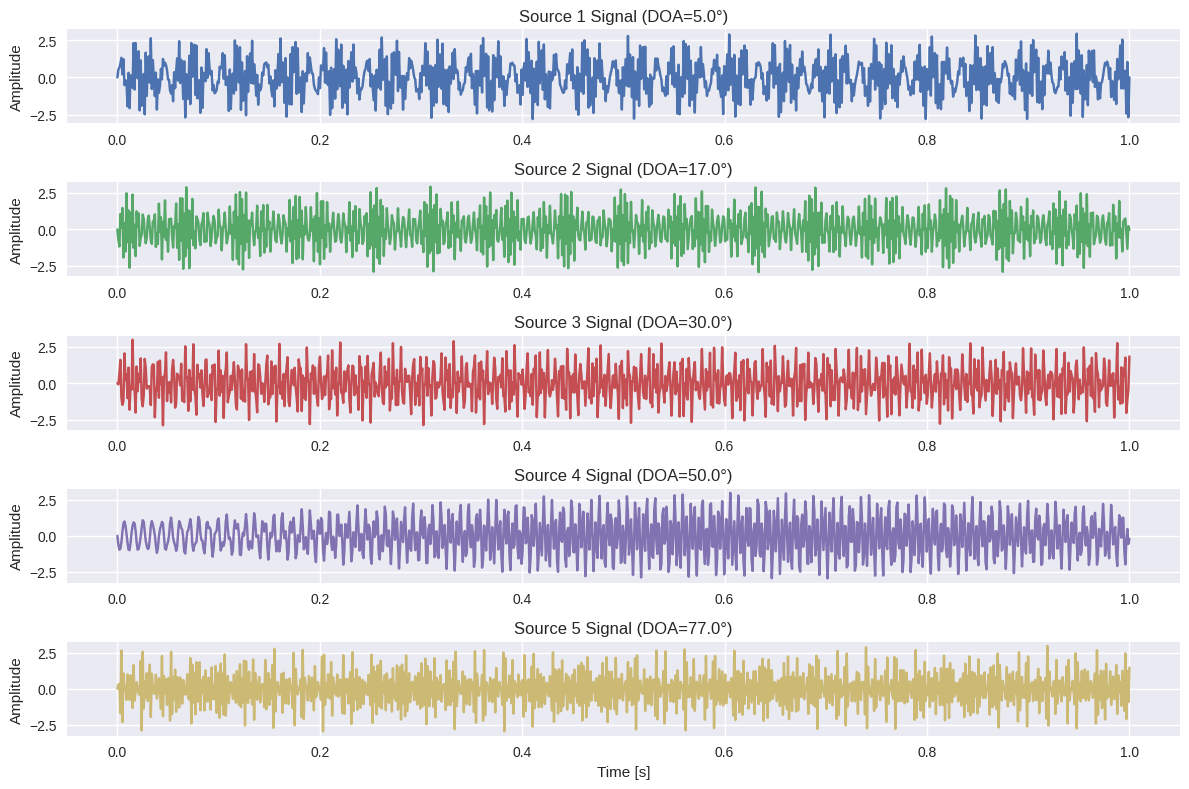

In [82]:
S = np.zeros((num_sources, len(t)))
for i in range(num_sources):
    S[i, :] = generate_source_signal(t, freqs_per_source=3, freq_range=(50, 900))

# Plot source signals
plt.figure(figsize=(12, 8))
for i in range(num_sources):
    plt.subplot(num_sources, 1, i+1)
    plt.plot(t, S[i], color=f'C{i}')
    plt.title(f"Source {i+1} Signal (DOA={angles[i]}°)")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

## **5. Steering Matrix and Received Signals**

In [83]:
# Steering matrix
A = np.zeros((M, num_sources), dtype=complex)
for i, angle in enumerate(angles):
    theta = np.deg2rad(angle)
    A[:, i] = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta))

# Additive noise
signal_power = np.mean(np.abs(A @ S)**2)
noise_power = signal_power / 10**(SNR_dB/10)
N = np.sqrt(noise_power/2) * (np.random.randn(M, len(t)) + 1j * np.random.randn(M, len(t)))

# Received signals
X = A @ S + N

# Verify shapes
print("Steering matrix A:", A.shape)
print("Source signals S:", S.shape)
print("Noise N:", N.shape)
print("Received signals X:", X.shape)

Steering matrix A: (32, 5)
Source signals S: (5, 1000)
Noise N: (32, 1000)
Received signals X: (32, 1000)


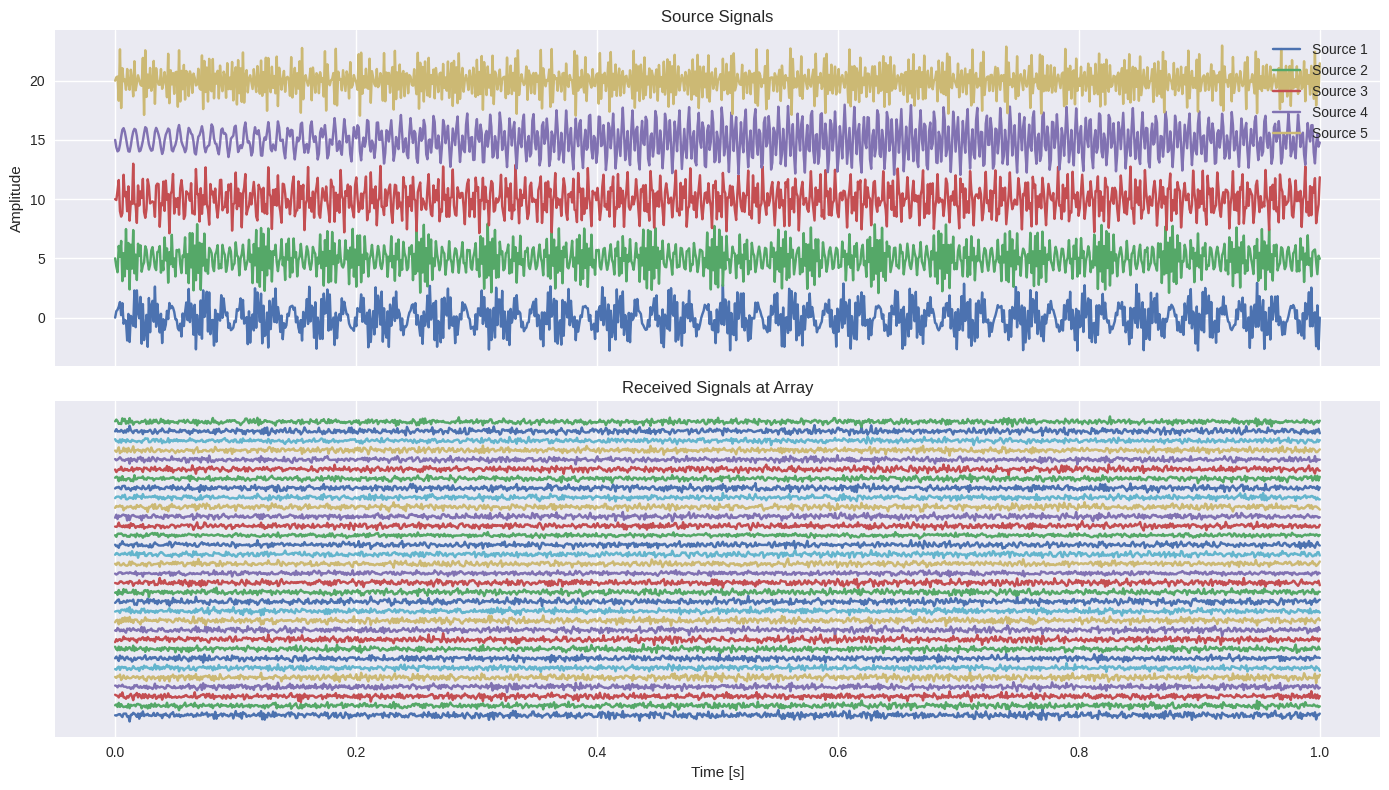

In [84]:
# Plot Received Signals
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original sources (shifted for clarity)
for i in range(num_sources):
    axs[0].plot(t, S[i] + i*5, label=f"Source {i+1}")
axs[0].set_title("Source Signals")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].grid(True)

# Received array signals
offset = 1.5 * np.max(np.abs(X.real))
for m in range(M):
    axs[1].plot(t, X[m].real + m*offset, label=f"Sensor {m+1}")
axs[1].set_title("Received Signals at Array")
axs[1].set_xlabel("Time [s]")
axs[1].set_yticks([])
axs[1].grid(True)

plt.tight_layout()
plt.show()

## **6. Spatial Correlation Matrix**

$$
\mathbf{R}_{xx} = \frac{1}{N} \mathbf{X} \mathbf{X}^H
$$

In [85]:
Rxx = (X @ X.conj().T) / X.shape[1]
Rxx_df = pd.DataFrame(np.abs(Rxx))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Rxx_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,13.041347,4.222682,1.316106,2.236291,0.660187,1.100812,1.177089,1.104464,4.429317,6.503896,2.646066,3.470424,4.128776,1.288313,1.981869,1.631287,1.536652,3.570597,4.969445,1.718731,5.178394,5.724175,1.106290,1.538018,1.412351,2.077862,2.123658,2.504758,1.921122,6.829891,6.051245,0.545968
1,4.222682,13.139983,4.211010,1.042567,1.797093,0.977917,1.397521,1.591769,1.354418,4.990015,7.289231,2.672990,3.180918,3.416957,1.236931,1.967480,2.398715,2.040989,3.791173,5.230481,1.015227,5.316858,5.436486,1.454273,2.099617,1.889775,1.802921,2.156396,2.787245,1.943414,7.201955,5.851515
2,1.316106,4.211010,14.099143,4.614896,1.076335,2.182617,0.403670,0.885900,1.105691,1.398604,4.283472,6.792606,3.232873,3.091987,4.124492,1.643532,1.601598,1.979640,2.211005,4.007839,5.098736,1.101536,5.655458,6.021596,1.725454,1.835828,1.359088,1.426768,2.119089,2.983227,2.143450,7.204567
3,2.236291,1.042567,4.614896,13.694909,4.277777,1.167722,1.774588,0.874383,1.481087,1.786309,1.324149,4.581452,6.768042,2.649027,3.131922,3.919699,1.460295,2.141304,2.326003,1.791235,4.118696,4.499714,1.447510,5.598586,5.515953,2.087343,1.681672,1.610577,1.652040,2.304413,2.517776,2.236566
4,0.660187,1.797093,1.076335,4.277777,13.704270,4.450483,0.821814,1.719825,0.662847,1.417001,1.824639,1.304606,4.787403,6.851547,2.775921,3.183214,4.122513,1.380755,1.810146,1.765485,2.041126,3.761360,5.229182,1.189478,5.646662,5.880230,2.037444,1.954010,1.456576,2.128136,2.062255,2.884026
5,1.100812,0.977917,2.182617,1.167722,4.450483,13.681107,4.250841,1.087332,2.178689,0.829154,1.461666,0.965069,1.542581,4.765914,6.966406,2.739445,3.589483,4.115684,0.863090,1.465049,1.388168,1.944217,3.510272,4.934222,0.771872,5.563268,6.069673,1.953255,1.918474,1.459781,1.848830,2.199044
6,1.177089,1.397521,0.403670,1.774588,0.821814,4.250841,13.641832,4.230571,0.687682,2.221256,0.845012,1.485916,1.535767,1.441760,5.044516,7.091002,2.926598,3.300122,3.989610,1.525342,1.526002,1.848862,2.080170,3.683375,5.072766,1.265861,5.603563,5.265345,1.682221,1.379429,2.019949,1.325229
7,1.104464,1.591769,0.885900,0.874383,1.719825,1.087332,4.230571,14.342970,4.928417,1.492958,2.751222,0.982895,1.764435,1.433690,1.143912,4.552328,6.652469,2.597335,3.881871,4.311430,1.688214,1.662697,1.736617,1.855595,3.632494,5.243992,0.391535,5.819635,6.178667,1.827088,2.014695,1.078877
8,4.429317,1.354418,1.105691,1.481087,0.662847,2.178689,0.687682,4.928417,13.853020,4.339409,0.827711,1.629501,1.499007,1.738264,1.420514,1.167118,4.293335,6.580645,2.881885,3.218818,3.970586,1.957493,1.805442,2.453527,1.880732,3.869670,5.263927,1.461613,5.775027,5.544275,1.919111,1.840148
9,6.503896,4.990015,1.398604,1.786309,1.417001,0.829154,2.221256,1.492958,4.339409,13.816040,4.442951,1.220894,1.832047,0.373225,1.446842,1.427760,1.820271,4.315651,7.288378,3.447605,3.059992,3.994001,1.230651,1.930275,2.026951,2.328069,4.019380,4.935315,1.723115,5.362696,5.516609,1.321188


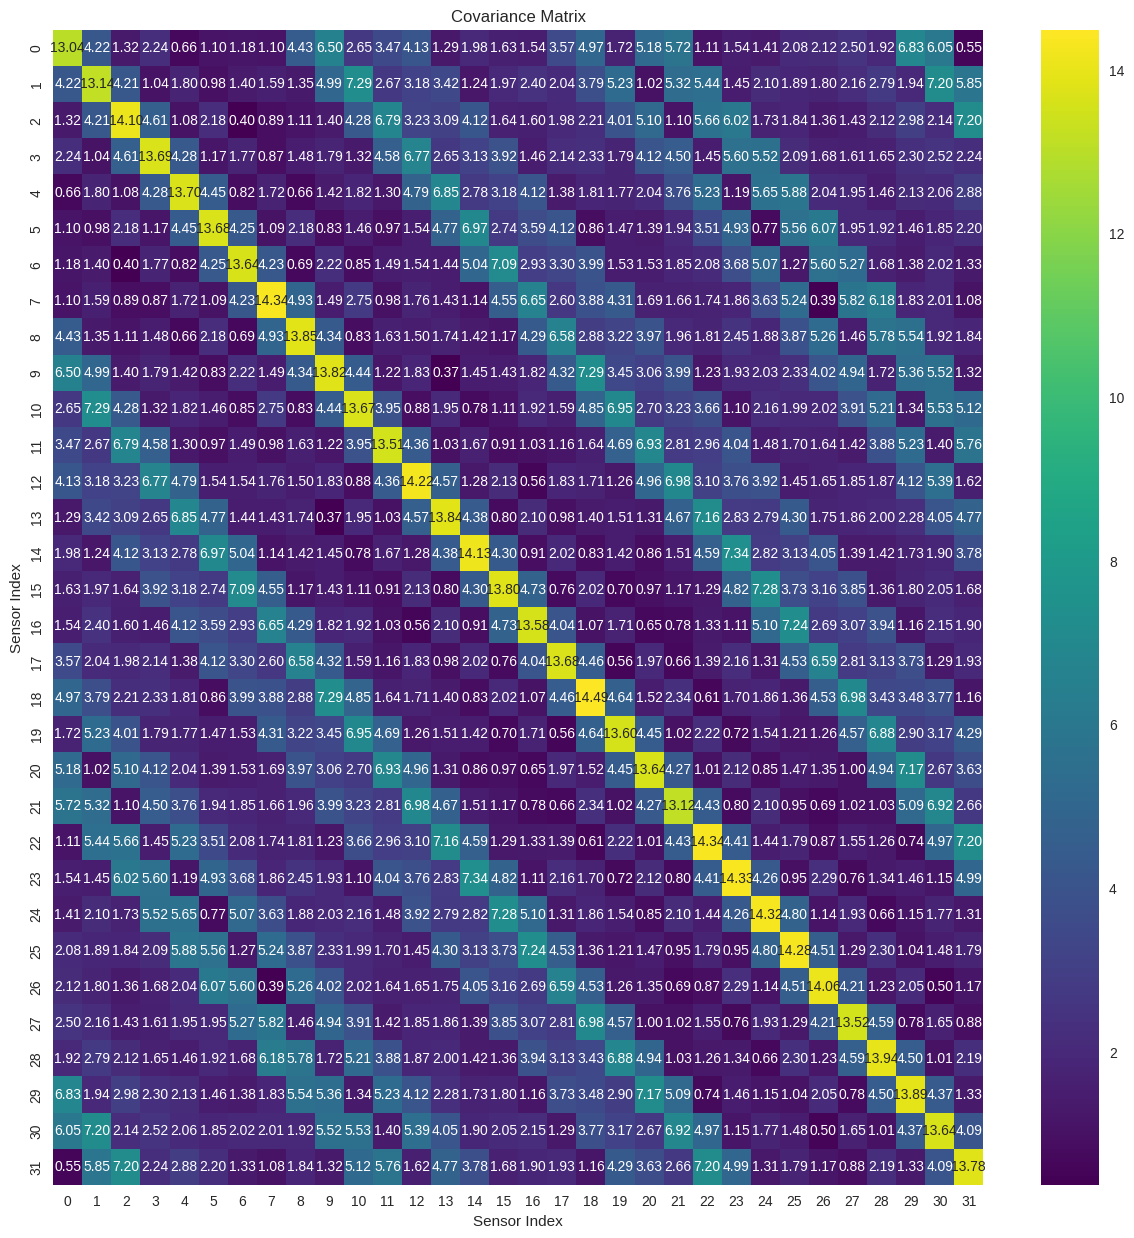

In [86]:
# Plot covariance matrix heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(Rxx), annot=True, fmt=".2f", cmap='viridis')
plt.title("Covariance Matrix")
plt.xlabel("Sensor Index")
plt.ylabel("Sensor Index")
plt.show()

## **7. MUSIC DOA Estimation**

The MUSIC spatial spectrum:

$$
P_{\text{MUSIC}}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{E}_n \mathbf{E}_n^H \mathbf{a}(\theta)}
$$

Where:
- $\mathbf{a}(\theta)$ — steering vector for angle $\theta$
- $\mathbf{E}_n$ — noise subspace (eigenvectors of smallest eigenvalues of $\mathbf{R}_{xx}$)

In [87]:
# Function for MUSIC DOA Estimation
def music_doa_estimation(X, num_sources, d=0.5, scan_angles=np.arange(-90, 91, 0.1)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N
    eigvals, eigvecs = np.linalg.eigh(Rxx)  # eigh for Hermitian
    idx = eigvals.argsort()[::-1]
    eigvecs = eigvecs[:, idx]
    En = eigvecs[:, num_sources:]  # Noise subspace

    P_music = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta)).reshape(-1,1)
        P = 1 / np.abs(a.conj().T @ En @ En.conj().T @ a)
        P_music.append(P[0,0].real)

    return np.array(scan_angles), np.array(P_music)

# Snapshot-Averaged MUSIC Estimation
def snapshot_averaged_music(X, num_sources, N_snapshots=5, scan_angles=np.arange(-90, 91, 0.1)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P_music = music_doa_estimation(X_snap, num_sources, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P_music
        else:
            P_avg += P_music
    P_avg /= N_snapshots
    return scan_angles, P_avg

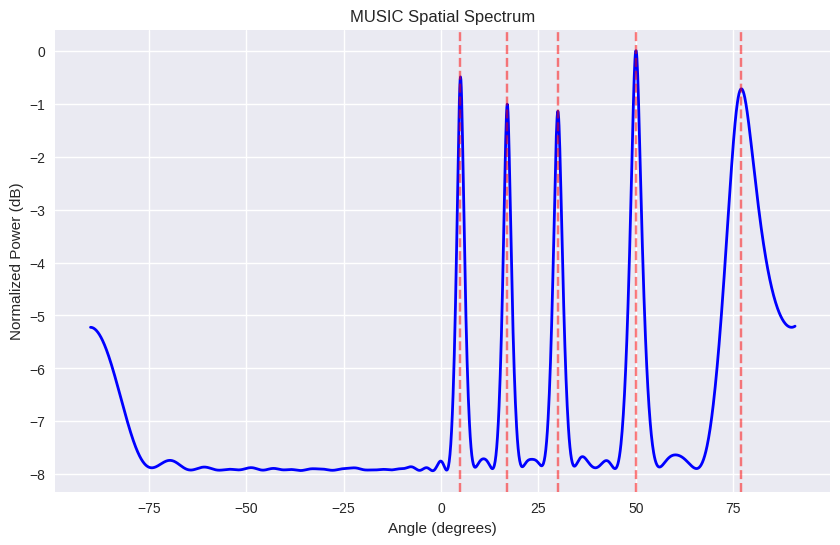

In [88]:
scan_angles, P_music_avg = snapshot_averaged_music(X, num_sources, N_snapshots=50)

# Plot MUSIC Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_music_avg/np.max(P_music_avg)), linewidth=2, color='b')
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("MUSIC Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()

In [89]:
# Find peaks
peaks, properties = find_peaks(
    P_music_avg,
    height=np.mean(P_music_avg) + 2 * np.std(P_music_avg),  # Adaptive threshold
    prominence=0.2 * np.max(P_music_avg),  # Significant peaks
    distance=20,  # 2° separation
)
estimated_DOAs = scan_angles[peaks]

# Handle missed detections by checking lengths
if len(estimated_DOAs) < len(angles):
    estimated_DOAs = np.append(estimated_DOAs, [0]*(len(angles) - len(estimated_DOAs)))
    print("Warning: Some DOAs were not detected; added zeros for missed detections.")

# Convert to floats and sort
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [5.0, 17.0, 30.0, 50.1, 77.1]
Original DOAs (degrees): [5.0, 17.0, 30.0, 50.0, 77.0]


In [90]:
def calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean):
    try:
        # Compute RMSE / MSE
        rmse = np.sqrt(np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2))
        mse = np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2)
        print(f"RMSE: {rmse:.2f}°, MSE: {mse:.2f}°")
    except ValueError:
        print("Error in RMSE/MSE calculation: Mismatched number of estimated and original DOAs.")

In [91]:
calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean)

RMSE: 0.06°, MSE: 0.00°


## **8. Capon (MVDR) DOA Estimation**

Capon (MVDR) spatial spectrum:

$$
P_\text{Capon}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{R}_{xx}^{-1} \mathbf{a}(\theta)}
$$
where $\mathbf{R}_{xx}$ is the spatial correlation matrix.

In [92]:
# Function for Capon DOA Estimation
def capon_doa_estimation(X, d=0.5, scan_angles=np.arange(-90,91,0.1)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N        # Spatial correlation matrix
    Rxx_inv = np.linalg.pinv(Rxx)     # Pseudo-inverse for stability
    P_capon = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j*2*np.pi*d*np.arange(M)*np.sin(theta)).reshape(-1,1)
        P = 1 / np.real(a.conj().T @ Rxx_inv @ a)
        P_capon.append(P[0,0])
    return np.array(scan_angles), np.array(P_capon)

# Snapshot-Averaged Capon
def snapshot_averaged_capon(X, N_snapshots=5, d=0.5, scan_angles=np.arange(-90,91,0.1)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P = capon_doa_estimation(X_snap, d=d, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P
        else:
            P_avg += P
    P_avg /= N_snapshots
    return scan_angles, P_avg

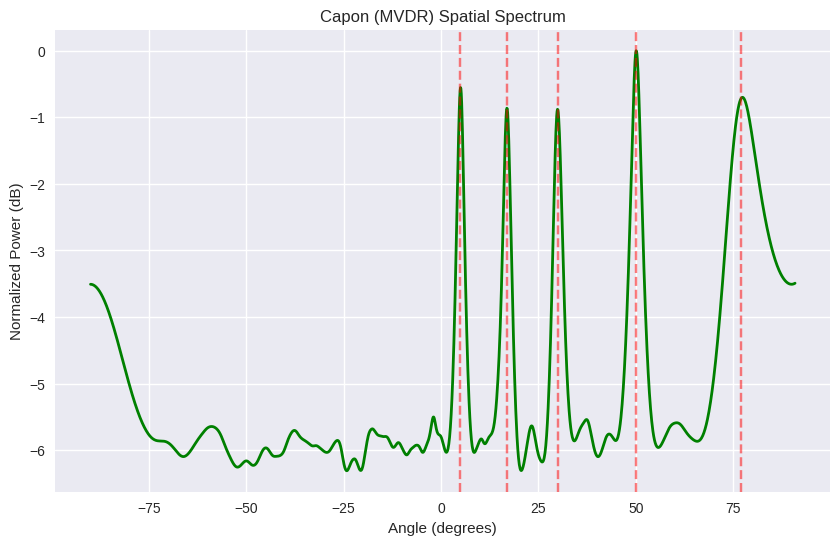

In [93]:
scan_angles, P_capon_avg = snapshot_averaged_capon(X, N_snapshots=50)

# Plot Capon Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_capon_avg/np.max(P_capon_avg)), linewidth=2, color='g')
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("Capon (MVDR) Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()


In [94]:
# Detect peaks
peaks, properties = find_peaks(
    P_music_avg,
    height=np.mean(P_music_avg) + 2 * np.std(P_music_avg),  # Adaptive threshold
    prominence=0.2 * np.max(P_music_avg),  # Significant peaks
    distance=20,  # 2° separation
)
estimated_DOAs = scan_angles[peaks]

# Handle missed detections by checking lengths
if len(estimated_DOAs) < len(angles):
    estimated_DOAs = np.append(estimated_DOAs, [0]*(len(angles) - len(estimated_DOAs)))
    print("Warning: Some DOAs were not detected; added zeros for missed detections.")

# Sort and convert to floats
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [5.0, 17.0, 30.0, 50.1, 77.1]
Original DOAs (degrees): [5.0, 17.0, 30.0, 50.0, 77.0]


In [95]:
# Compute RMSE / MSE
calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean)

RMSE: 0.06°, MSE: 0.00°


## **Comparison Between MUSIC and Capon**

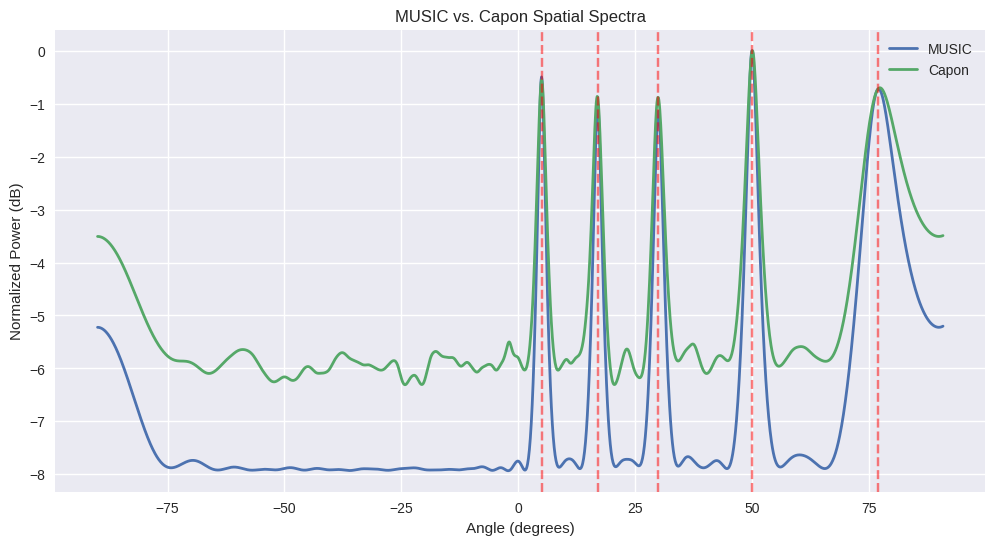

In [96]:
# Plot MUSIC and Capon Spectra Together
plt.figure(figsize=(12, 6))
plt.plot(scan_angles, 10 * np.log10(P_music_avg / np.max(P_music_avg)), label='MUSIC', linewidth=2)
plt.plot(scan_angles, 10 * np.log10(P_capon_avg / np.max(P_capon_avg)), label='Capon', linewidth=2)
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("MUSIC vs. Capon Spatial Spectra")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.legend()
plt.grid(True)
plt.show()